# Topic Clustering using Sentence Embeddings

In [1]:
import os
import sys
PATH = '/home/piotr/projects/twitter'
PATH_DATA = os.path.join(PATH, 'data/clean/')
PATH_RESULTS = os.path.join(PATH, 'results/topics/kmeans')
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
sys.path.append(os.path.join(PATH, 'src'))
START = '2020_02_23'
END = '2020_07_19' #end date (last file)
TRAIN_SIZE = 0.15

In [2]:
import pickle
import gc
import numpy as np
import pandas as pd
from itertools import chain, product
from functools import partial
import re
import json
import pdb
import gc
import ast


import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
tqdm.pandas()

from gensim.models import KeyedVectors
from nltk import FreqDist, word_tokenize
from twitter_models.embeddings import KTopicModel
from twitter_tools.utils import read_files, batch, VectorDictLowMemory, VectorDict
import twitter_tools.evaluation.topics as evaluation

PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        stopwords.append(line.strip('\n'))
stopwords.append('mieć')
dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Introduction
In this notebook, I evaluate Tweet topic clustering obtained through the method specified by Demszky et al. in accordance with the sentence embeddings method proposed by Arora et al. 2017. For each Tweet, its embedding was calculated as the weighted sum of its lemmatized tokens, where the weights where tokens' respective weights were inversly proportional to each token's probability of occurence, using a normalzing constant $a$, such that $w = \frac{a}{ap(w)}$ Clustering was done using Minibatch K Means clustering algorithm, using sample of 10% of the total unique tweets, stratified w.r.t the date and party alligiance, to ensure the representativeness of the results.

### Data loading
The data is loaded from the preprocessed files, additionally excluding the ids flagged as problematic by the analysis performed in the `preprocessing` notebook. The Tweets that included less than 50% of Polish vocabulary or were tagged as outliers are also removed. Below, I define a filter function which is used toegether with the data loader function `read_files` specified in the module `twitter_tools.utils`.

In [5]:
drop_users = json.load(open(os.path.join(PATH, 'results/cleaning/drop_users.json'), 'r'))
drop_tweets = json.load(open(os.path.join(PATH, 'results/cleaning/drop_tweets.json'), 'r'))
def filter_fun(df, drop_users, drop_tweets, drop_duplicates = True, cols = 'all'):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    if drop_duplicates:
        df.drop_duplicates(inplace = True)
    if cols != 'all':
        df = df[cols]
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets, cols = ['full_text','lemmatized','source', 'day', 'lemmas'])

In [4]:
PATH_SAMPLE = os.path.join(PATH, 'data/clean/topic_sample' + '_' + START + '_' + END + '.csv')
if os.path.isfile(PATH_SAMPLE):
    data = pd.read_csv(PATH_SAMPLE, index_col = 0, dtype = dtypes)
else:
    data = pd.DataFrame()
    for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, 
                               filter_fun = ff, method = 'pandas')):
        dat.lemmas = dat.lemmas.apply(ast.literal_eval)
        dat.drop_duplicates(subset = ['full_text'], inplace = True)
        dat = dat.groupby('source').apply(lambda x: x.sample(frac = TRAIN_SIZE, random_state = 1234))
        data = data.append(dat)
        gc.collect()
    data.drop_duplicates(subset = ['full_text'], inplace = True)
    data.reset_index(inplace = True, drop = True)
    data.to_csv(PATH_SAMPLE)
data['lemmas'] = data['lemmas'].astype(str).apply(ast.literal_eval)
print(f'Data loadead. Train size {len(data["lemmas"])}')

Data loadead. Train size 857786


## Evaluation methods:

1. Inertia, i.e. the within-cluster sum of squares.
2. Silhuette score
3. Mean and sd of first topic similarity to its cluster
4. Mean and sd of the ratio of first to second topic similarity 

## Grid Search
To identify the optimal clustering hyperparameters (number of centroids `k` and the `a` inverse frequency weighting constant) I performed a grid search over a range of parameters, computing the silhuette score on 10% of the training data and obtaining the within-cluster sum of squares.

In [19]:
def grid_search(text:list, folder_results:str, path_embeddings:str, verbose = False, save = False):
    #set up grid:
    keys = params.keys(); combs = product(*params.values()) #keys + all combinations of parameters
    grid = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts
    print(f'Number of params to be evaluated {len(grid)}')
    
    #iterate over parameter combinations
    for i, param in enumerate(tqdm(grid)): 
        ktp = KTopicModel(k = param["k"], 
                          a = param["a"], 
                          ncomp = param["ncomp"], 
                          path_embeddings = path_embeddings, 
                          random_state = 1234)
        
        #FIT
        ktp.fit(text)
        
        #EVALUATE:
        grid[i]['silhuette'] = ktp.evaluate(text, sample_size = round(0.1 * len(text)), random_state = 1234)
        grid[i]['inertia'] = ktp.cluster.inertia_
        
        #predict a sample of the data:
        preds = ktp.predict(np.random.choice(text, int(0.1*len(text))), return_closest = False)
        preds = [sorted(pred.items(), key = lambda x: x[1], reverse = True) for pred in preds]
        
        #best topic similarity:
        best_score = [pred[0][1] for pred in preds]
        grid[i]['similarity_mean'] = np.mean(best_score)
        grid[i]['similarity_sd'] = np.std(best_score)
        
        #ratio of best to second best:
        ratios = [pred[0][1]/pred[1][1] for pred in preds]
        grid[i]['ratio_mean'] = np.mean(ratios)
        grid[i]['ratio_sd'] = np.std(ratios)
        if verbose:
            print(f'Done evaluating {i} out of {len(grid)}. \
            K: {grid[i]["k"]} \
            A: {grid[i]["a"]} \
            Silhuette score {round(grid[i]["silhuette"], 4)}. \
            Inertia {round(grid[i]["inertia"], 4)} \
            Mean similarity: {round(grid[i]["similarity_mean"], 4)} \
            Mean ratio: {round(grid[i]["ratio_mean"], 4)}')
        #save:
        if save:
            pickle.dump(ktp, open(os.path.join(folder_results, f'cluster_n_{ktp.ncomp}_k_{ktp.k}_a_{ktp.a}.p'), 'wb'))
        del ktp
        gc.collect()
    return grid

### 1. Using glove vectors trained locally on the polarization dataset (50-dimensional):

In [36]:
%%time
PATH_EMBEDDINGS = '/home/piotr/nlp/glove/vectors.txt'
PATH_COMPARISON = os.path.join(PATH_RESULTS, 'grid_search_glove.json')
if os.path.isfile(PATH_COMPARISON):
    results = json.load(open(PATH_COMPARISON, 'r'))
else:
    #run grid search:
    params = {'k':list(range(6, 30, 2)), 'a':[None, 1, 1e-3], 'ncomp':[0, 1, 2]}
    results = grid_search(data.lemmas, PATH_RESULTS, PATH_EMBEDDINGS, verbose = True)
    json.dump(results, open(PATH_COMPARISON, 'w'))

CPU times: user 0 ns, sys: 3.36 ms, total: 3.36 ms
Wall time: 18 ms


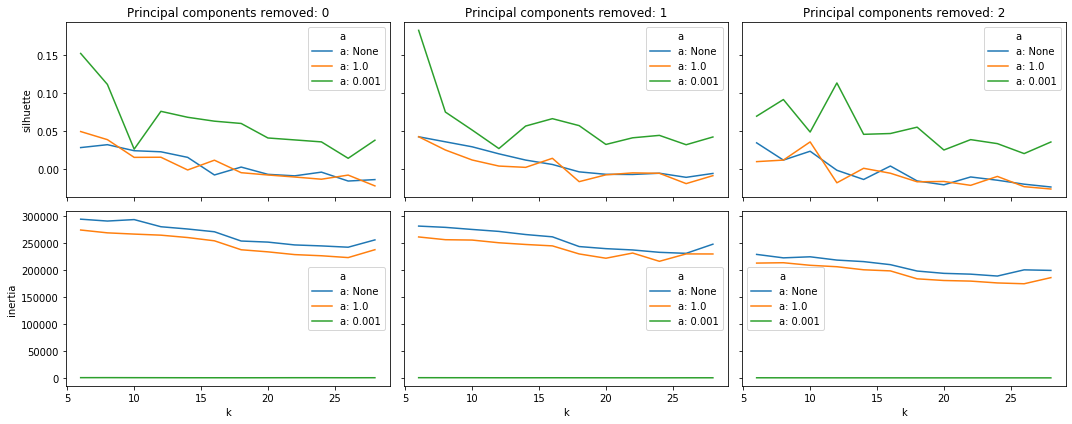

     k         a  ncomp  silhuette     inertia  similarity_mean  \
7    6  a: 0.001      1   0.182350  891.921300         0.577112   
6    6  a: 0.001      0   0.151948  951.182627         0.895794   
35  12  a: 0.001      2   0.113085  633.091179         0.656683   
15   8  a: 0.001      0   0.111132  994.685373         0.900059   
17   8  a: 0.001      2   0.091258  684.016242         0.608965   
33  12  a: 0.001      0   0.075741  855.452329         0.912176   
16   8  a: 0.001      1   0.074767  830.672566         0.633464   
8    6  a: 0.001      2   0.069339  731.012912         0.586707   
42  14  a: 0.001      0   0.067909  778.431237         0.913523   
52  16  a: 0.001      1   0.066082  769.558528         0.680631   
51  16  a: 0.001      0   0.062777  768.306815         0.917350   
60  18  a: 0.001      0   0.059764  741.031105         0.919523   
61  18  a: 0.001      1   0.056912  741.090070         0.695567   
43  14  a: 0.001      1   0.056362  737.204228         0.66368

In [37]:
results = pd.DataFrame(results)
results['a'] = np.where(results['a'].isna(), 'None', results['a'])
results['a'] = "a: " + results['a'].astype(str)
fig, ax = plt.subplots(2, 3, figsize = (15, 6), sharex = True, sharey = 'row')
ax = ax.ravel()
for i, (val, subdf) in enumerate(results.groupby('ncomp')):
    sns.lineplot(x = "k", y = "silhuette", hue = "a", ax = ax[i], data = subdf)
    ax[i].set_title(f'Principal components removed: {val}')
for i, (val, subdf) in enumerate(results.groupby('ncomp')):
    sns.lineplot(x = "k", y = "inertia", hue = "a", ax = ax[i+3], data = subdf)
plt.tight_layout()
plt.show()
print(results.sort_values(['silhuette', 'inertia'], ascending = False)[:15])

#### Fit model and predict:

In [21]:
PATH_EMBEDDINGS = '/home/piotr/nlp/glove/vectors.txt'
ktp = KTopicModel(k = 10, a = 1.0, ncomp = 1, path_embeddings = PATH_EMBEDDINGS, random_state = 1234)
ktp.fit(data.lemmas.tolist())

#### Examine centroids similarity:

In [22]:
glove = VectorDict().read_file(PATH_EMBEDDINGS, dim = 50)
centroid_dict  = {k:c for k, c in enumerate(glove.most_similar_by_vectors(ktp.cluster.cluster_centers_, n = 10))}
centroid_dict_noscores = {k:[w[0] for w in v] for k, v in centroid_dict.items()}

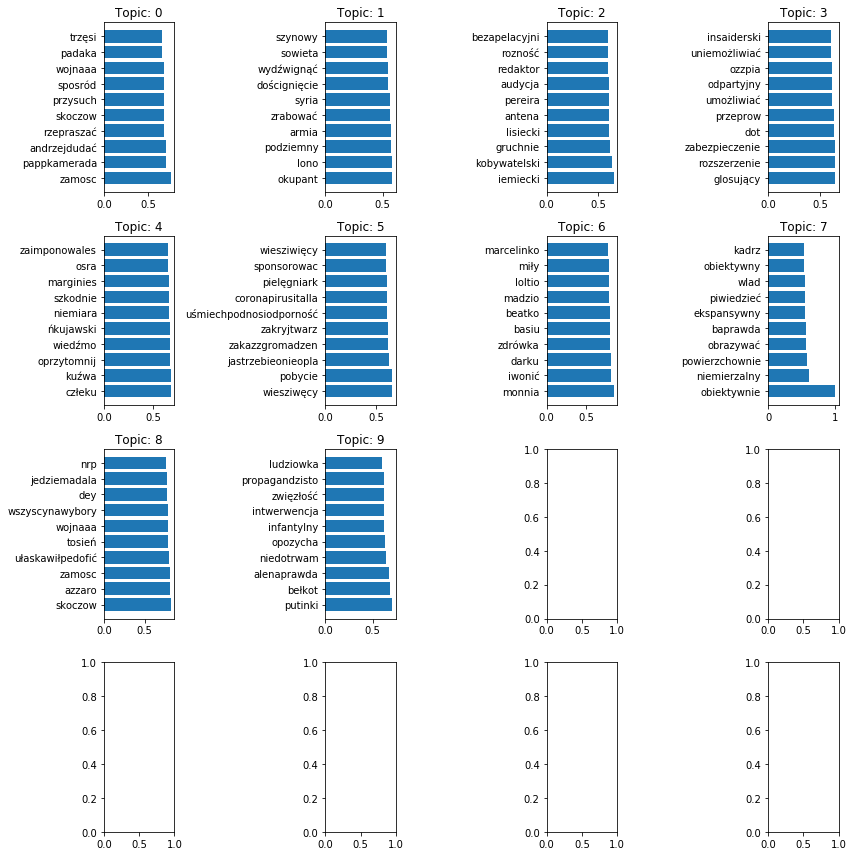

In [23]:
side = int(np.ceil(np.sqrt(len(centroid_dict))))
fig, ax = plt.subplots(side, side, figsize = (12, 12))
ax = ax.ravel()
for i, (k, v) in enumerate(centroid_dict.items()):
    ax[i].barh([elem[0] for elem in v], [elem[1] for elem in v])
    ax[i].set_title(f'Topic: {k}')
plt.tight_layout()
plt.show()

#### Look at difficulty to classify and predict:

In [24]:
threshold = 0.25 #drop below threshold quantile
topics = ktp.predict(data.lemmatized)
ratios = []
for i, topic in enumerate(topics):
    topics[i] = sorted(topic.items(), key = lambda x: x[1], reverse = True)
    ratios.append(topics[i][0][1]/topics[i][1][1])
unk = np.where(ratios <= np.quantile(ratios, 0.1))[0] #difficult to categorize
topics = [topic[0][0] if i not in unk else 'unk' for i, topic in enumerate(topics)]
data['topic'] = topics

#### Examine token distribution:

In [25]:
topics = sorted(np.unique(data['topic'].astype(str)))
side = int(np.ceil(np.sqrt(len(topics))))
fig, ax = plt.subplots(side, side, figsize = (12, 12))
ax = ax.ravel()
for i, topic in enumerate(topics):
    tmp = data[data['topic'].astype(str) == topic].lemmas.apply(ast.literal_eval)
    fd = FreqDist(chain.from_iterable(tmp))
    common_tokens = fd.most_common(10)
    ax[i].barh([w[0] for w in common_tokens], [w[1] for w in common_tokens])
    ax[i].set_title(f'Topic {topic}')
plt.tight_layout()
plt.show()

ValueError: malformed node or string: ['pięć', 'rok', 'udać']

In [ ]:
topic_subset = None
aggregate = data.groupby(['topic','day']).size().reset_index().rename(columns = {0:'num'}) #get counts by day and topic
daycounts = aggregate.groupby('day').agg({'num':np.sum})['num'] #get counts by day for normalization
aggregate['num'] = aggregate['num'].div(aggregate['day'].map(daycounts)) #normalize count
if topic_subset is not None:
    aggregate = aggregate[aggregate['topic'].isin(topic_subset)]
aggregate = aggregate.pivot(index = 'day', columns = 'topic', values = 'num') #reshape
#plot
fig, ax = plt.subplots(1, 1, figsize = (16, 12))
aggregate.plot.area(ax = ax, cmap = 'tab20c')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_ylabel('Proportion of tweets')
ax.set_xlabel('Date')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Predict topics for the entire dataset:

In [17]:
threshold = 0.25 #drop below threshold quantile
ff = partial(filter_fun, drop_duplicates = False, 
             drop_users = drop_users, drop_tweets = drop_tweets, 
             cols = ['lemmatized','source', 'day', 'id_str'])
topic_map = dict()
for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, 
                           filter_fun = ff, method = 'pandas')):
    dat.lemmatized = dat.lemmatized.apply(lambda x: [w for w in x.split() if w not in stopwords])
    topics = ktp.predict(dat.lemmatized.astype(str))
    ratios = []
    for i, topic in enumerate(topics):
        topics[i] = sorted(topic.items(), key = lambda x: x[1], reverse = True)
        ratios.append(topics[i][0][1]/topics[i][1][1])
    unk = np.where(ratios <= np.quantile(ratios, 0.1))[0] #difficult to categorize
    topics = [topic[0][0] if i not in unk else 'unk' for i, topic in enumerate(topics)]
    topic_map.update(dict(zip(dat['id_str'], topics)))
    json.dump(topic_map, open(os.path.join(PATH, 'results/topics/kmeans/best_model_topics.json'), 'w'))
    print(pd.value_counts(list(topic_map.values())))
    del topic_map